Found 1840 interactome files.


  0%|          | 0/1840 [00:00<?, ?it/s]

mean: 544.0581521739131, max: 16415, min: 5


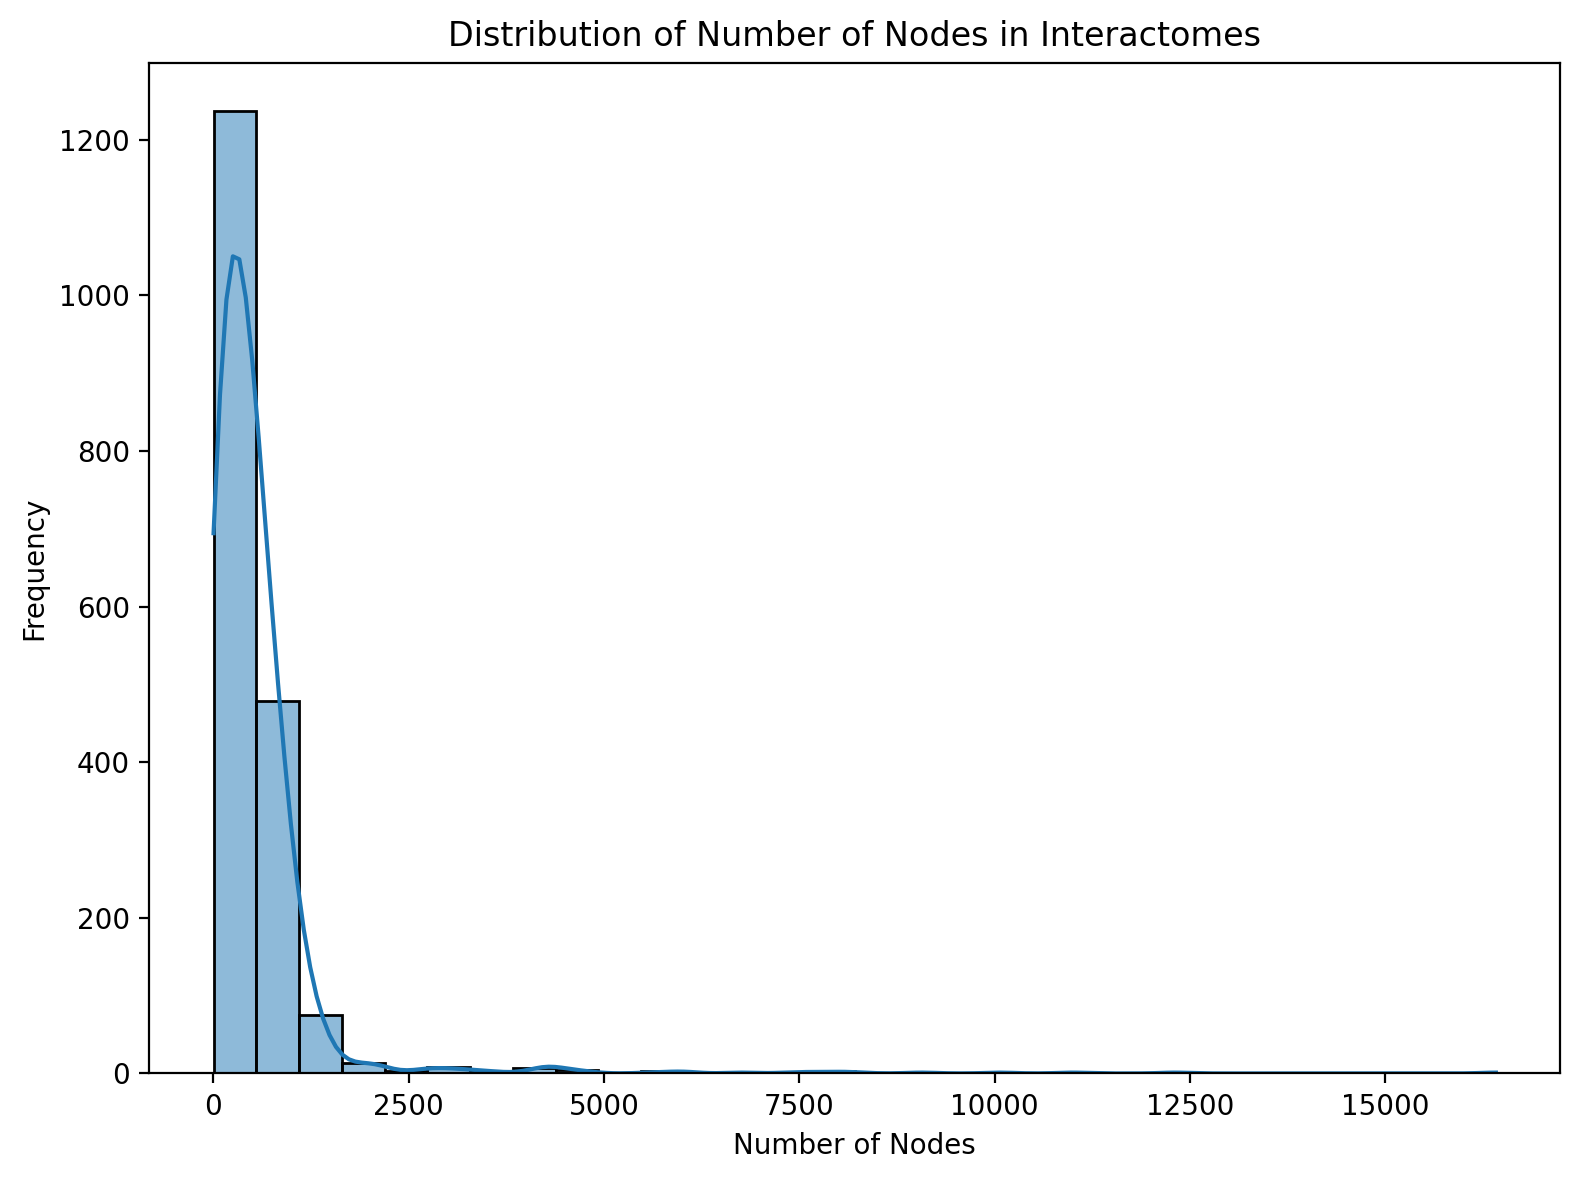

In [1]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import json

def read_edge_list_as_adjacency(filename):
    """
    Reads an edge list file into a NumPy adjacency matrix.
    Each line should have two node IDs separated by space.

    Returns:
        adj_matrix (np.ndarray): NxN adjacency matrix
        nodes (list): list of node names in the same order as matrix indices
    """
    edges = []
    nodes = set()

    # read file and collect nodes + edges
    with open(filename, "r") as f:
        for line in f:
            u, v = line.strip().split()
            edges.append((u, v))
            nodes.update([u, v])

    # assign index to each node
    nodes = sorted(nodes)
    node2idx = {node: i for i, node in enumerate(nodes)}

    # build adjacency matrix
    n = len(nodes)
    adj = np.zeros((n, n), dtype=int)
    for u, v in edges:
        i, j = node2idx[u], node2idx[v]
        adj[i, j] = 1

    return adj, nodes

data_dir = '../data/treeoflife.interactomes.max_cc'
save_dir = '../data/treeoflife.interactomes.max_cc_adj'
node_save_dir = '../data/treeoflife.interactomes.max_cc_nodes'
interactome_list = []
for file in os.listdir(data_dir):
    if file.endswith('.txt'):
        interactome_list.append(os.path.join(data_dir, file))
print(f"Found {len(interactome_list)} interactome files.")

num_nodes = []
os.makedirs(save_dir, exist_ok=True)
os.makedirs(node_save_dir, exist_ok=True)
for interactome in tqdm(interactome_list):
    adj, nodes = read_edge_list_as_adjacency(interactome)
    num_nodes.append(len(nodes))
    np.savez_compressed(os.path.join(save_dir, os.path.basename(interactome).replace('.txt', '.npz')), adj=adj)
    np.savetxt(os.path.join(node_save_dir, os.path.basename(interactome).replace('.txt', '_nodes.txt')), nodes, fmt='%s')
print(f'mean: {np.mean(num_nodes)}, max: {np.max(num_nodes)}, min: {np.min(num_nodes)}')

# plot the distribution of number of nodes
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
sns.histplot(num_nodes, bins=30, kde=True, ax=ax)
ax.set_title('Distribution of Number of Nodes in Interactomes')
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import os

data_dir = '../data/treeoflife.interactomes.max_cc_adj'
interactome_list = []
for file in os.listdir(data_dir):
    if file.endswith('.npz'):
        interactome_list.append(os.path.join(data_dir, file))
print(f"Found {len(interactome_list)} interactome files.")
for interactome in interactome_list:
    data = np.load(interactome)
    adj = data['adj']
    if 2000 < len(adj) < 3000 :
        print(f'{interactome} {len(adj)}')

Found 1840 interactome files.
../data/treeoflife.interactomes.max_cc_adj/29760.npz 2017
../data/treeoflife.interactomes.max_cc_adj/7897.npz 2993
../data/treeoflife.interactomes.max_cc_adj/4081.npz 2133
../data/treeoflife.interactomes.max_cc_adj/3694.npz 2870
../data/treeoflife.interactomes.max_cc_adj/4558.npz 2013
../data/treeoflife.interactomes.max_cc_adj/13735.npz 2714
../data/treeoflife.interactomes.max_cc_adj/4555.npz 2065
../data/treeoflife.interactomes.max_cc_adj/59689.npz 2243
../data/treeoflife.interactomes.max_cc_adj/1148.npz 2149
../data/treeoflife.interactomes.max_cc_adj/28377.npz 2620
../data/treeoflife.interactomes.max_cc_adj/9103.npz 2042
../data/treeoflife.interactomes.max_cc_adj/88036.npz 2760
../data/treeoflife.interactomes.max_cc_adj/7739.npz 2112
../data/treeoflife.interactomes.max_cc_adj/316407.npz 2756


In [ ]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def visualize_network(G, title="Network Graph"):
    # G is a numpy adjacency matrix
    graph = nx.from_numpy_array(G)
    plt.figure(figsize=(3, 3), dpi=100)
    nx.draw(graph, node_color='blue', edge_color='gray', node_size=20, alpha=0.7)

data_file = '../data/treeoflife.interactomes.max_cc_adj/7260.npz'
data = np.load(data_file)
adj = data['adj']
print(f'Adjacency matrix shape: {adj.shape}')
print(f'Number of edges: {np.sum(adj) // 2}')  # undirected graph
visualize_network(adj, title="Interactome Network Visualization")

In [ ]:
import numpy as np
from collections import deque

def connected_component_sizes(adj: np.ndarray) -> list[int]:
    """
    Return sizes of all connected components of a graph given by its adjacency matrix.

    Parameters
    ----------
    adj : np.ndarray
        Square adjacency matrix (n x n). Nonzero means an edge. Treated as undirected.

    Returns
    -------
    list[int]
        Sizes of all connected components.
    """
    if adj.ndim != 2 or adj.shape[0] != adj.shape[1]:
        raise ValueError("adj must be a square 2D numpy array")

    n = adj.shape[0]
    # Treat as undirected: union with transpose; remove self-loops from neighbor finding
    undirected = (adj != 0) | (adj.T != 0)
    np.fill_diagonal(undirected, False)

    visited = np.zeros(n, dtype=bool)
    sizes = []

    for start in range(n):
        if visited[start]:
            continue
        # BFS from 'start'
        q = deque([start])
        visited[start] = True
        size = 0
        while q:
            u = q.popleft()
            size += 1
            # neighbors of u where there is an edge and not visited
            nbrs = np.flatnonzero(undirected[u] & ~visited)
            if nbrs.size:
                visited[nbrs] = True
                q.extend(nbrs.tolist())
        sizes.append(size)

    return sizes

data_file = '../data/treeoflife.interactomes_adj/930945.npz'
data = np.load(data_file)
adj = data['adj']
sizes = connected_component_sizes(adj)
sizes.sort(reverse=True)
print(f'Connected component sizes: {sizes}')
sizes = np.array(sizes)
N = adj.shape[0]
probs = sizes / N
entropy = -np.sum(probs * np.log(probs + 1e-10)) / np.log(N)
print(f'Shannon diversity index: {entropy:.4f}')